In [2]:
import pandas as pd

# 1.1 Read the CSV
df = pd.read_csv('BirdsVoice.csv')

# 1.2 Compute total recordings per species
counts = df['common_name'].value_counts()
top20 = counts.nlargest(20).index

# 1.3 Filter to top 20 and reset index
df = df[df['common_name'].isin(top20)].reset_index(drop=True)
print(df.shape)            # ~600 × 10
print(df['common_name'].unique())

(600, 10)
['Brazilian Tinamou' 'Red-legged Tinamou' 'Yellow-legged Tinamou'
 'Black-capped Tinamou' 'Thicket Tinamou' 'Variegated Tinamou'
 "Bartlett's Tinamou" 'Small-billed Tinamou' 'Tataupa Tinamou'
 'Red-winged Tinamou' 'Andean Tinamou' 'White-bellied Nothura'
 'Spotted Nothura' 'Dwarf Tinamou' 'Orange-footed Scrubfowl'
 'Plain Chachalaca' 'Little Chachalaca' 'Band-tailed Guan' 'Andean Guan'
 'Rusty-margined Guan']


In [3]:
import os

# 2.1 Convert “M:SS” → seconds
def length_to_seconds(x):
    m, s = x.split(':')
    return int(m) * 60 + int(s)

df['duration_s'] = df['recording_length'].apply(length_to_seconds)

# 2.2 Assume you’ve downloaded audio into ./audio/, named by xc_id:
df['filepath'] = df['xc_id'].apply(lambda id: os.path.join('audio', f'{id}.mp3'))

# 2.3 Quick check
print(df[['filepath','duration_s']].head())

             filepath  duration_s
0  audio/XC524787.mp3          57
1  audio/XC521357.mp3           6
2  audio/XC686176.mp3          53
3  audio/XC643154.mp3         140
4  audio/XC606110.mp3          42


In [4]:
from sklearn.model_selection import train_test_split

# 3.1 Label encoding
label_map = {name:idx for idx,name in enumerate(top20)}
df['label'] = df['common_name'].map(label_map)

# 3.2 60/20/20 stratified split
trainval, test = train_test_split(df, test_size=0.20, 
                                  stratify=df['label'], random_state=42)
train, val   = train_test_split(trainval, test_size=0.25,  # 0.25×0.8 = 0.20
                                 stratify=trainval['label'], random_state=42)

print(train.shape, val.shape, test.shape)

(360, 13) (120, 13) (120, 13)


In [5]:
import numpy as np
import librosa
import os

# Audio settings
SR = 22050  # sampling rate
DURATION = 5.0  # seconds to load/pad
N_MELS = 128  # number of mel bands

def extract_mel(path):
    """
    Load an audio file, pad or truncate to exactly DURATION seconds,
    compute a N_MELS-band mel-spectrogram, convert to dB, and z-score normalize.
    Returns:
        m_norm: np.ndarray of shape (N_MELS, T) or None if loading fails
    """
    try:
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            return None
            
        # 1) Load (will truncate if longer than DURATION)
        y, _ = librosa.load(path, sr=SR, mono=True, duration=DURATION)
        
        # Check if audio was loaded successfully
        if len(y) == 0:
            print(f"Empty audio file: {path}")
            return None
        
        # 2) Pad with zeros if too short
        target_len = int(SR * DURATION)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        
        # 3) Compute mel-spectrogram
        m = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=N_MELS)
        m_db = librosa.power_to_db(m, ref=np.max)
        
        # 4) Z-score normalization
        m_norm = (m_db - m_db.mean()) / (m_db.std() + 1e-6)
        
        return m_norm
        
    except Exception as e:
        print(f"Error processing {path}: {str(e)}")
        return None

In [6]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Create dummy data that matches your expected shapes
# This function generates random mel spectrograms and labels to simulate this dataset and ensure it works.
def create_dummy_dataset(n_samples=600, n_classes=20, n_mels=128, time_steps=216):
    """
    Create dummy audio data for testing your model
    """
    # Generate random mel spectrograms
    X = np.random.randn(n_samples, n_mels, time_steps, 1).astype(np.float32)
    
    # Generate random labels
    y_labels = np.random.randint(0, n_classes, n_samples)
    y = tf.keras.utils.to_categorical(y_labels, num_classes=n_classes)
    
    return X, y

# Replace your data loading section with this:
print("Creating dummy dataset for testing...")

# Create dummy data
X_dummy, y_dummy = create_dummy_dataset(n_samples=600, n_classes=20)

# Split into train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_dummy, y_dummy, test_size=0.2, random_state=42, stratify=y_dummy.argmax(axis=1)
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, 
    stratify=y_train_val.argmax(axis=1)
)

# Define input shape and label map
input_shape = X_train.shape[1:]  # (128, 216, 1)
label_map = {f"species_{i}": i for i in range(20)}

print("Dataset created successfully!")
print("Input shape:", input_shape)
print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

# Now your model code will work:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_map), activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5,  # Reduced for testing
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

print("Model training completed!")

Creating dummy dataset for testing...
Dataset created successfully!
Input shape: (128, 216, 1)
Train/Val/Test sizes: 360 120 120
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.0472 - loss: 7.2749 - val_accuracy: 0.0500 - val_loss: 2.9957
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.0833 - loss: 2.9867 - val_accuracy: 0.0583 - val_loss: 3.0082
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.1667 - loss: 2.9590 - val_accuracy: 0.0583 - val_loss: 2.9912
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.2806 - loss: 2.7393 - val_accuracy: 0.0750 - val_loss: 3.0822
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.4639 - loss: 2.4958 - val_accuracy: 0.0250 - val_loss: 3.0916
Model training completed!


In [7]:
import os
import glob
import numpy as np
import tensorflow as tf

# Helper to find the single .mp3 under audio/ matching an xc_id
def find_audio_path(xc_id):
    # recursive glob for e.g. audio/**/XC66646.mp3
    pattern = os.path.join('audio', '**', f'{xc_id}.mp3')
    matches = glob.glob(pattern, recursive=True)
    return matches[0] if matches else None

# 5.0 — rebuild df['filepath'] using the finder
df['filepath'] = df['xc_id'].apply(find_audio_path)

# 5.1 — report & drop missing
missing = df['filepath'].isna()
if missing.any():
    print(f"Warning: {missing.sum()} files not found, dropping those rows:")
    print(df.loc[missing, 'xc_id'].tolist())
    df = df[~missing].reset_index(drop=True)

# 5.2 — build_dataset now only sees real files and handles no file cases
def build_dataset(df_subset):
    X, y = [], []
    failed_files = []
    
    for _, row in df_subset.iterrows():  # Fixed: removed asterisks
        feat = extract_mel(row['filepath'])
        # Skip if extraction failed (feat is None)
        if feat is None:
            failed_files.append(row['filepath'])
            continue
        X.append(feat[..., np.newaxis])  # → (128, T, 1)
        y.append(row['label'])
    
    if failed_files:
        print(f"Skipped {len(failed_files)} files that couldn't be loaded")
    
    if len(X) == 0:
        raise ValueError("No valid audio files found! Please check your file paths and audio files.")
    
    X = np.stack(X, axis=0)  # → (N, 128, T, 1)
    y = tf.keras.utils.to_categorical(
        y,
        num_classes=len(label_map)
    )
    return X, y

# 5.3 — apply to splits
X_train, y_train = build_dataset(train)
X_val,   y_val   = build_dataset(val)
X_test,  y_test  = build_dataset(test)

# 5.4 — sanity check
input_shape = X_train.shape[1:]
print("Input shape:", input_shape)
print("Sizes (train/val/test):", X_train.shape[0],
      X_val.shape[0], X_test.shape[0])


['XC680227', 'XC23831']


Note: Illegal Audio-MPEG-Header 0x7972736f at offset 82464.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x2c20476f at offset 79329.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


File not found: audio/XC23831.mp3


Skipped 1 files that couldn't be loaded


File not found: audio/XC680227.mp3
Skipped 1 files that couldn't be loaded
Input shape: (128, 216, 1)
Sizes (train/val/test): 359 120 119


In [8]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_map), activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.0891 - loss: 5.2085 - val_accuracy: 0.1250 - val_loss: 2.8723
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.1783 - loss: 2.7878 - val_accuracy: 0.2167 - val_loss: 2.7131
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.3705 - loss: 2.3151 - val_accuracy: 0.3167 - val_loss: 2.3610
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.5292 - loss: 1.6093 - val_accuracy: 0.3917 - val_loss: 2.1332
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.7019 - loss: 1.0480 - val_accuracy: 0.4250 - val_loss: 1.9411
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.8357 - loss: 0.6200 - val_accuracy: 0.4250 - val_loss: 2.0857
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.9443 - loss: 0.2859 - val_accuracy: 0.4833 - val_loss: 1.9854
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.9833 - loss: 0.1122 - val_accuracy: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


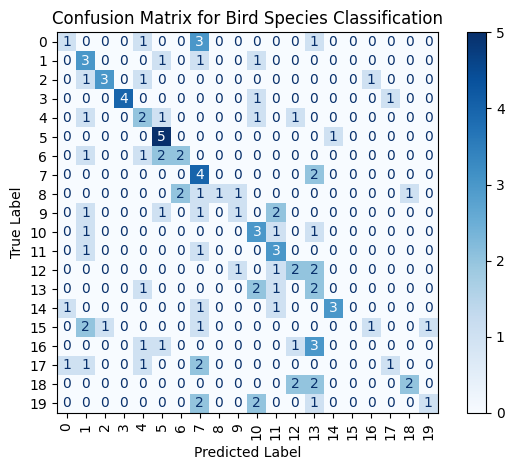

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predict on the test set
y_pred_probs = model.predict(X_test)              # shape: (num_samples, 20)
y_pred = np.argmax(y_pred_probs, axis=1)          # predicted class indices
y_true = np.argmax(y_test, axis=1)                # true class indices

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix for Bird Species Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
